In [20]:
import time
import pickle

import numpy as np
import random

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Configurations
save_stats = True
save_figs = False
train = True
load = not train

seed = 0

## 2. Q-Learning

In [3]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000 # number of episodes
num_avg = 1 # training runs
test_freq = 250

### 2.1 Learning from experts

#### Question 1: Average reward with $\epsilon = 0.1$

************** RUN 1 OF 1 **************
M_opt = 0.0
M_rand = 0.862
RUN 1 took 36.3 seconds
epsilon_exploration_Q1 = 0.1 : 	M_opt =  0.0 	M_rand =  0.862


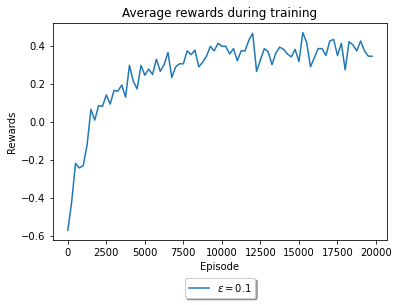

In [18]:
epsilon_exploration = 0.1
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)
    M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q1', '\epsilon', save=save_figs, keys = ['rewards'])

#### Questions 2 and 3: Decreasing exploration for different values of $n^{*}$

In [19]:
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [20]:
vec_n_star_first = vec_n_star[:10]
var_name = 'nstar_first'
q_learning_params_list = []
for n_star in vec_n_star_first:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'against_opt': True}
    q_learning_params_list.append(params)

In [21]:
if train:
    stats_dict_nstar_first_list = train_avg(var_name, vec_n_star_first, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [22]:
var_name = 'nstar_second'
vec_n_star_second = vec_n_star[10:]
q_learning_params_list = []
for n_star in vec_n_star_second:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'against_opt': True}
    q_learning_params_list.append(params)

In [23]:
if train:
    stats_dict_nstar_second_list = train_avg(var_name, vec_n_star_second, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

In [24]:
# Merge
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_first_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_first_list = pickle.load(handle)
    fname = output_folder + '/stats_dict_nstar_second_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_second_list = pickle.load(handle)
        for i in range(len(stats_dict_nstar_second_list)):
            stats_dict_nstar_list.append({**stats_dict_nstar_first_list[i], **stats_dict_nstar_second_list[i]})
    fname = output_folder + '/stats_dict_nstar_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.878
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.872
n_star = 19127.0 : 	M_opt =  0.0 	M_rand =  0.854
n_star = 40000 : 	M_opt =  0.0 	M_rand =  0.874


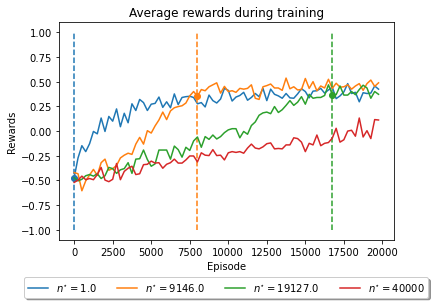

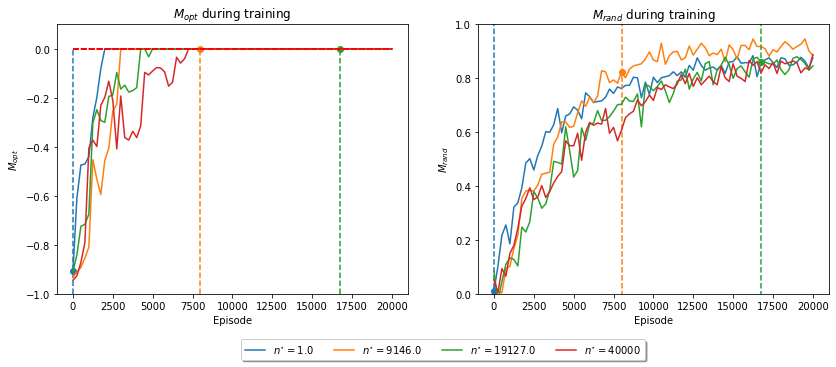

In [25]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star', "n^{\star}", save=save_figs, decaying_exploration=True)

##### Plot for all the experimented values

n_star = 1.0 : 	M_opt =  0.0 	M_rand =  0.878
n_star = 100.0 : 	M_opt =  0.0 	M_rand =  0.81
n_star = 500.0 : 	M_opt =  0.0 	M_rand =  0.84
n_star = 750.0 : 	M_opt =  0.0 	M_rand =  0.854
n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.868
n_star = 1279.0 : 	M_opt =  0.0 	M_rand =  0.85
n_star = 1635.0 : 	M_opt =  0.0 	M_rand =  0.874
n_star = 2091.0 : 	M_opt =  0.0 	M_rand =  0.842
n_star = 2674.0 : 	M_opt =  0.0 	M_rand =  0.888
n_star = 3420.0 : 	M_opt =  0.0 	M_rand =  0.898
n_star = 4373.0 : 	M_opt =  0.0 	M_rand =  0.852
n_star = 5593.0 : 	M_opt =  0.0 	M_rand =  0.846
n_star = 7152.0 : 	M_opt =  0.0 	M_rand =  0.824
n_star = 9146.0 : 	M_opt =  0.0 	M_rand =  0.872
n_star = 11696.0 : 	M_opt =  0.0 	M_rand =  0.812
n_star = 14957.0 : 	M_opt =  0.0 	M_rand =  0.88
n_star = 19127.0 : 	M_opt =  0.0 	M_rand =  0.854
n_star = 24460.0 : 	M_opt =  0.0 	M_rand =  0.826
n_star = 31279.0 : 	M_opt =  0.0 	M_rand =  0.86
n_star = 40000.0 : 	M_opt =  0.0 	M_rand =  0.874


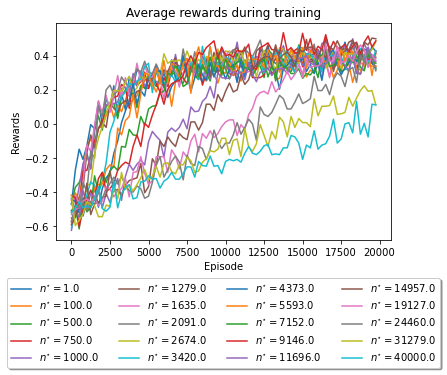

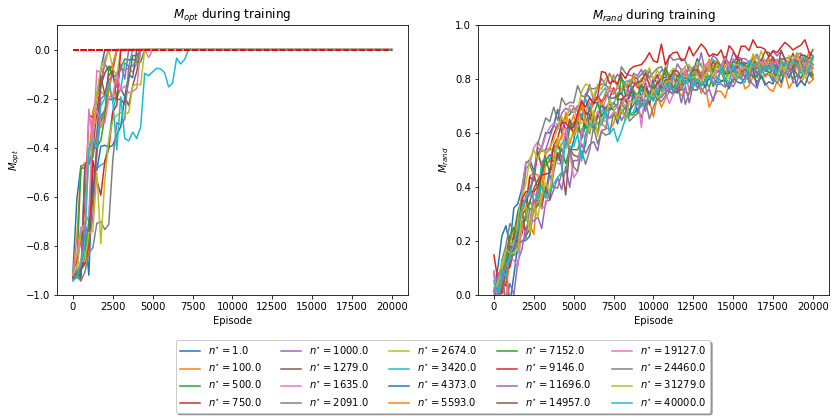

In [26]:
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Questions 4: Good experts and bad experts

In [27]:
n_star = 1 # we pick the best according to previous experiments
M = 11
var_name = 'epsilon_opt'
vec_epsilon_opt = np.round(np.linspace(0, 1, M), decimals=2)
q_learning_params_list = []
for epsilon_opt in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': 250,
              'epsilon_opt': epsilon_opt,
              'against_opt': True}
    q_learning_params_list.append(params)

In [28]:
if train:
    stats_dict_eps_opt_list = train_avg(var_name, vec_epsilon_opt, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.09
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.664
epsilon_opt = 0.5 : 	M_opt =  0.0 	M_rand =  0.818
epsilon_opt = 0.8 : 	M_opt =  -0.112 	M_rand =  0.852
epsilon_opt = 1.0 : 	M_opt =  -0.286 	M_rand =  0.896


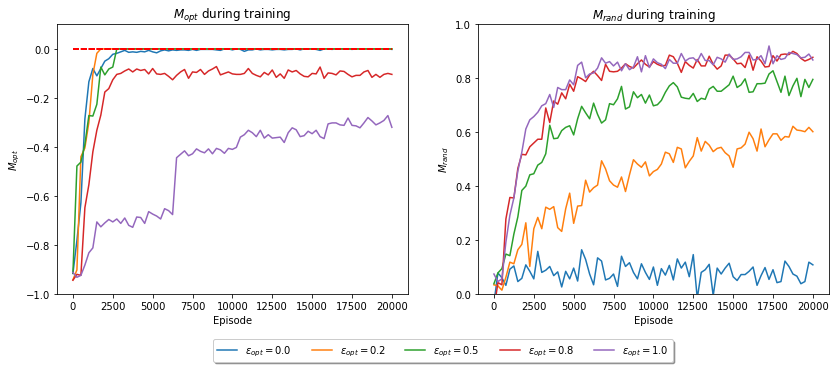

In [29]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

plot_epsilon_opt = [0., 0.2, 0.5, 0.8, 1.]
plot_stats(stats_dict_eps_opt_list, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs, keys=['test_Mopt', 'test_Mrand'])

##### Plot for all the experimented values

In [ ]:
plot_stats(stats_dict_eps_opt_list, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 5: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
np.random.seed(seed)
random.seed(seed)
# Setting hyperparams
n_star = 1
epsilon_min = 0.1
epsilon_max = 0.8
# Training
Q, stats = q_learning(env, num_episodes=20000, epsilon_exploration_rule=return_lambda_explor(epsilon_min, epsilon_max, n_star), verbose=False, epsilon_opt=0.5, against_opt=True)
# Measuring performance
m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
print("M_opt = ", m_opt)
m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
print("M_rand = ", m_rand)

### 2.2 Learning by self-practice

#### Question 7: Self-learning with constant rate of exploration $\epsilon$

In [25]:
epsilon_vec = np.array([0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
# epsilon_vec = np.array([0, 0.1, 0.5])
var_name = 'eps_self'
q_learning_params_list = []
for eps in epsilon_vec:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True }
    q_learning_params_list.append(params)
# epsilon_vec = np.hstack((epsilon_vec_plot, np.setdiff1d(np.logspace(-4, -1, 10), epsilon_vec_plot)))

In [26]:
if train:
    stats_dict_eps_self_list = train_avg(var_name, epsilon_vec, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

************** RUN 1 OF 1 **************
------------- Training with eps_self = 0.0 -------------
M_opt = -0.656
M_rand = 0.296
Training with eps_self = 0.0  took: 00h02m40s 


------------- Training with eps_self = 0.0001 -------------
M_opt = -0.936
M_rand = 0.182
Training with eps_self = 0.0001  took: 00h02m30s 


------------- Training with eps_self = 0.0005 -------------
M_opt = -0.922
M_rand = 0.26
Training with eps_self = 0.0005  took: 00h02m31s 


------------- Training with eps_self = 0.001 -------------
M_opt = -0.992
M_rand = 0.204
Training with eps_self = 0.001  took: 00h02m37s 


------------- Training with eps_self = 0.005 -------------
M_opt = -0.466
M_rand = 0.358
Training with eps_self = 0.005  took: 00h02m32s 


------------- Training with eps_self = 0.01 -------------
M_opt = -0.458
M_rand = 0.69
Training with eps_self = 0.01  took: 00h02m41s 


------------- Training with eps_self = 0.05 -------------
M_opt = -0.36
M_rand = 0.584
Training with eps_self = 0.05  took:

epsilon_self = 0 : 	M_opt =  -0.656 	M_rand =  0.296
epsilon_self = 0.1 : 	M_opt =  -0.094 	M_rand =  0.618
epsilon_self = 0.5 : 	M_opt =  -0.312 	M_rand =  0.884


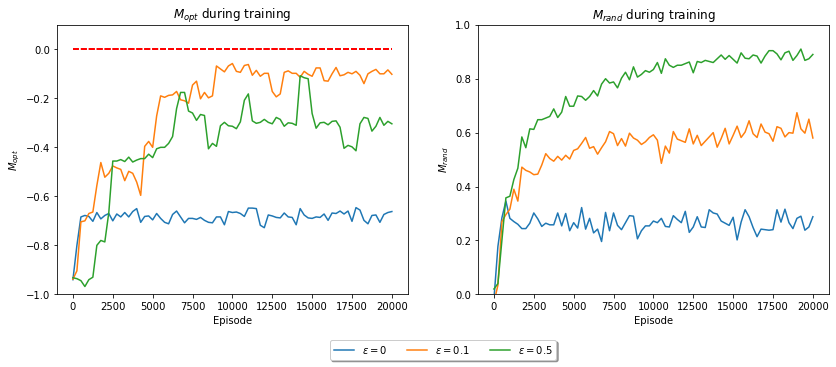

In [27]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self_list = pickle.load(handle)

epsilon_vec_plot = [0, 0.1, 0.5] # are these okay?
plot_stats(stats_dict_eps_self_list, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs, keys=['test_Mopt', 'test_Mrand'])

##### Plot for all the experimented values

epsilon_self = 0.0 : 	M_opt =  -0.656 	M_rand =  0.296
epsilon_self = 0.0001 : 	M_opt =  -0.936 	M_rand =  0.182
epsilon_self = 0.0005 : 	M_opt =  -0.922 	M_rand =  0.26
epsilon_self = 0.001 : 	M_opt =  -0.992 	M_rand =  0.204
epsilon_self = 0.005 : 	M_opt =  -0.466 	M_rand =  0.358
epsilon_self = 0.01 : 	M_opt =  -0.458 	M_rand =  0.69
epsilon_self = 0.05 : 	M_opt =  -0.36 	M_rand =  0.584
epsilon_self = 0.1 : 	M_opt =  -0.094 	M_rand =  0.618
epsilon_self = 0.5 : 	M_opt =  -0.312 	M_rand =  0.884
epsilon_self = 1.0 : 	M_opt =  -0.418 	M_rand =  0.918


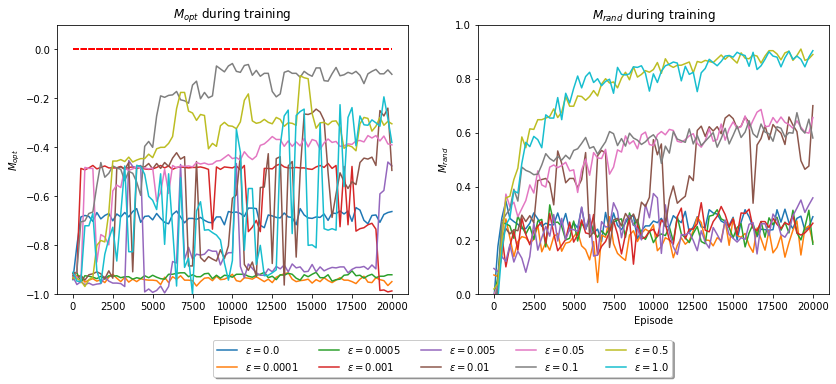

In [30]:
plot_stats(stats_dict_eps_self_list, epsilon_vec, "epsilon_self", "\epsilon", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 8: Decaying exploration rule for different values of $n^*$

In [31]:
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [33]:
var_name = 'nstar_first_self'
vec_n_star_first = vec_n_star[:10]
q_learning_params_list = []
for n_star in vec_n_star_first:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [34]:
if train:
    stats_dict_nstar_self_first_list = train_avg(var_name, vec_n_star_first, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

************** RUN 1 OF 1 **************
------------- Training with nstar_first_self = 1.0 -------------
M_opt = -0.46
M_rand = 0.64
Training with nstar_first_self = 1.0  took: 00h02m47s 


------------- Training with nstar_first_self = 100.0 -------------
M_opt = -0.304
M_rand = 0.72
Training with nstar_first_self = 100.0  took: 00h02m49s 


------------- Training with nstar_first_self = 500.0 -------------
M_opt = -0.132
M_rand = 0.706
Training with nstar_first_self = 500.0  took: 00h02m45s 


------------- Training with nstar_first_self = 750.0 -------------
M_opt = -0.338
M_rand = 0.68
Training with nstar_first_self = 750.0  took: 00h02m40s 


------------- Training with nstar_first_self = 1000.0 -------------
M_opt = -0.434
M_rand = 0.734
Training with nstar_first_self = 1000.0  took: 00h02m44s 


------------- Training with nstar_first_self = 1279.0 -------------
M_opt = -0.282
M_rand = 0.648
Training with nstar_first_self = 1279.0  took: 00h02m39s 


------------- Training with

In [35]:
var_name = 'nstar_second_self'
vec_n_star_second = vec_n_star[10:]
q_learning_params_list = []
for n_star in vec_n_star_second:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': (return_lambda_explor(epsilon_min, epsilon_max, n_star)),
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

In [36]:
if train:
    stats_dict_nstar_test = train_avg(var_name, vec_n_star_second, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

************** RUN 1 OF 1 **************
------------- Training with nstar_second_self = 4373.0 -------------
M_opt = -0.104
M_rand = 0.802
Training with nstar_second_self = 4373.0  took: 00h02m47s 


------------- Training with nstar_second_self = 5593.0 -------------
M_opt = -0.184
M_rand = 0.802
Training with nstar_second_self = 5593.0  took: 00h02m42s 


------------- Training with nstar_second_self = 7152.0 -------------
M_opt = -0.192
M_rand = 0.838
Training with nstar_second_self = 7152.0  took: 00h02m43s 


------------- Training with nstar_second_self = 9146.0 -------------
M_opt = -0.096
M_rand = 0.786
Training with nstar_second_self = 9146.0  took: 00h02m45s 


------------- Training with nstar_second_self = 11696.0 -------------
M_opt = -0.104
M_rand = 0.772
Training with nstar_second_self = 11696.0  took: 00h02m40s 


------------- Training with nstar_second_self = 14957.0 -------------
M_opt = -0.296
M_rand = 0.826
Training with nstar_second_self = 14957.0  took: 00h02m40

In [37]:
# Merge
if save_stats:
    stats_dict_nstar_self_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_first_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_first_self_list = pickle.load(handle)
    fname = output_folder + '/stats_dict_nstar_second_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_second_self_list = pickle.load(handle)
        for i in range(len(stats_dict_nstar_second_self_list)):
            stats_dict_nstar_self_list.append({**stats_dict_nstar_first_self_list[i], **stats_dict_nstar_second_self_list[i]})
    fname = output_folder + '/stats_dict_nstar_self_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_self_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_self = 1.0 : 	M_opt =  -0.46 	M_rand =  0.64
n_star_self = 100.0 : 	M_opt =  -0.304 	M_rand =  0.72
n_star_self = 1000.0 : 	M_opt =  -0.434 	M_rand =  0.734
n_star_self = 9146.0 : 	M_opt =  -0.096 	M_rand =  0.786
n_star_self = 14957.0 : 	M_opt =  -0.296 	M_rand =  0.826
n_star_self = 31279.0 : 	M_opt =  0.0 	M_rand =  0.95
n_star_self = 40000.0 : 	M_opt =  -0.102 	M_rand =  0.902


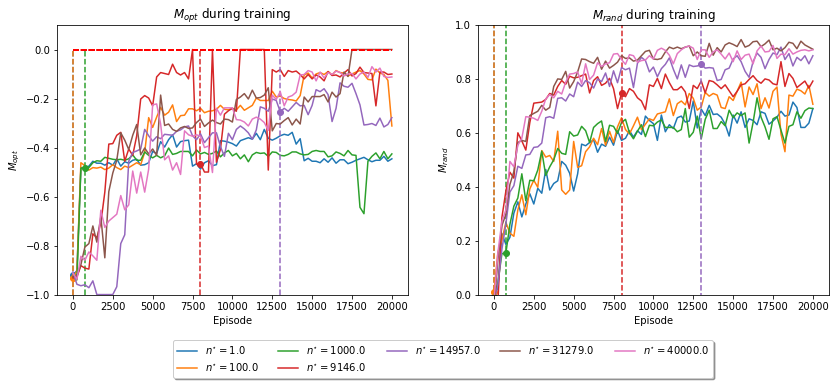

In [38]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_nstar_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_self_list = pickle.load(handle)

plot_n_star = [1., 100., 1000., 9146., 14957., 31279., 40000.]
plot_stats(stats_dict_nstar_self_list, plot_n_star, 'n_star_self', "n^{\star}", decaying_exploration=True, save=save_figs, keys=['test_Mopt', 'test_Mrand'])

##### Plot for all the experimented values

n_star_self = 1.0 : 	M_opt =  -0.46 	M_rand =  0.64
n_star_self = 100.0 : 	M_opt =  -0.304 	M_rand =  0.72
n_star_self = 500.0 : 	M_opt =  -0.132 	M_rand =  0.706
n_star_self = 750.0 : 	M_opt =  -0.338 	M_rand =  0.68
n_star_self = 1000.0 : 	M_opt =  -0.434 	M_rand =  0.734
n_star_self = 1279.0 : 	M_opt =  -0.282 	M_rand =  0.648
n_star_self = 1635.0 : 	M_opt =  -0.334 	M_rand =  0.676
n_star_self = 2091.0 : 	M_opt =  -0.218 	M_rand =  0.648
n_star_self = 2674.0 : 	M_opt =  -0.496 	M_rand =  0.598
n_star_self = 3420.0 : 	M_opt =  -0.228 	M_rand =  0.808
n_star_self = 4373.0 : 	M_opt =  -0.104 	M_rand =  0.802
n_star_self = 5593.0 : 	M_opt =  -0.184 	M_rand =  0.802
n_star_self = 7152.0 : 	M_opt =  -0.192 	M_rand =  0.838
n_star_self = 9146.0 : 	M_opt =  -0.096 	M_rand =  0.786
n_star_self = 11696.0 : 	M_opt =  -0.104 	M_rand =  0.772
n_star_self = 14957.0 : 	M_opt =  -0.296 	M_rand =  0.826
n_star_self = 19127.0 : 	M_opt =  -0.362 	M_rand =  0.804
n_star_self = 24460.0 : 	M_opt =  0.0 

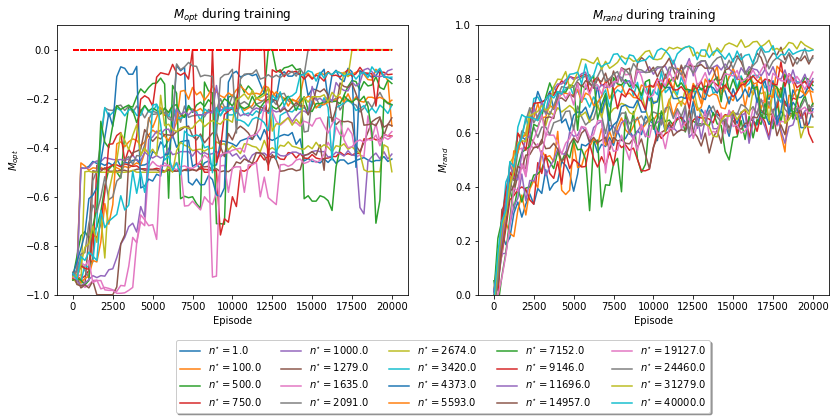

In [39]:
plot_stats(stats_dict_nstar_self_list, vec_n_star, 'n_star_self', "n^{\star}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [46]:
#np.random.seed(seed)
#random.seed(seed)
# Setting hyperparams
n_star = 31279
epsilon_min = 0.1
epsilon_max = 0.8
# Training
Q, stats = q_learning(env, num_episodes=20000, epsilon_exploration_rule=return_lambda_explor(epsilon_min, epsilon_max, n_star), verbose=False, self_practice=True)
# Measuring performance
m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
print("M_opt = ", m_opt)
m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
print("M_rand = ", m_rand)

M_opt =  0.0
M_rand =  0.888


#### Question 10: Heatmaps of the Q-values in 3 significant states

In [ ]:
# Parametri ottimali di Q
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 15000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
Q, stats = q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, verbose=True, self_practice=True)

In [ ]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [-1., 0., 0., 1., -1., 0., 0., 1., 0.], [1., -1., 0., 0., 0., 0., 0., 0., 0.]]
heatmaps_subplots(grids, Q, save=save_figs)

## Deep Q-Learning